In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/.conda/envs/psps/bin/python
farshed.abdukhakimov
cn-02
/home/farshed.abdukhakimov/projects/root-newton


In [2]:
import os
import sys
import urllib.request
import datetime
from collections import defaultdict

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.utils.data as data_utils
import torch.optim as optim

import torchvision
import torchvision.models as models

from sklearn.datasets import load_svmlight_file, make_classification

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/psps/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [4]:
# PyTorch Logistic Regression

def logreg(w, X, y, mu=1e-5):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w)))) + mu/2 * torch.norm(w)**2

def grad_logreg(w, X, y, mu=1e-5):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0] + mu * w

def hess_logreg(w, X, y, mu=1e-5):
    r = torch.exp(-y * (X @ w))
    return ( X.T @ (  (r/torch.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0] + mu * torch.eye(X.shape[1])

# NumPy Logistic Regression

def lgstc(w, X, y, lmd=1e-5):
  return np.mean(np.log(1 + np.exp( - X@w * y ))) + lmd/2 * np.linalg.norm(w)**2

def dlgstc(w, X, y, lmd=1e-5):
  r = np.exp( - X@w * y )
  ry = -r/(1+r) * y
  return (X.T @ ry )/X.shape[0]  + lmd * w

def d2lgstc(w, X, y, lmd=1e-5):
  r = np.exp( - X@w * y )
  rr= r/(1+r)**2
  return (X.T@np.diagflat(rr)@X) / X.shape[0] + lmd*np.eye(X.shape[1])
   

In [5]:
X = np.asarray([[1., 2., 3.], [0., 5., -2.], [4., 0., 10.]])
y = np.asarray([1., -1., 1.])
w = np.asarray([0.5, 1., 10.])

X_t = torch.asarray([[1., 2., 3.], [0., 5., -2.], [4., 0., 10.]])
y_t = torch.asarray([1., -1., 1.])
w_t = torch.asarray([0.5, 1., 10.]).requires_grad_()

loss = logreg(w_t, X_t, y_t)
closure = lambda w: logreg(w, X_t, y_t)
hess = torch.autograd.functional.hessian(closure, w_t)

assert torch.norm(hess - hess_logreg(w_t, X_t, y_t)) <= 1e-20
assert np.linalg.norm(hess - d2lgstc(w, X, y)) <= 1e-20

In [6]:
# torch.manual_seed(0)
# np.random.seed(0)

# dataset_name = "a1a"
# batch_size = 64

# datasets_path = os.getenv("LIBSVM_DIR")
# trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")

# train_data = torch.tensor(trainX.toarray())
# train_target = torch.tensor(trainY)

# train_load = TensorDataset(train_data, train_target)
# train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)

# train = train_data, train_target, train_dataloader


# loss_function = logreg
# loss_grad = grad_logreg
# loss_hessian = hess_logreg


# if loss_function == logreg:
#     train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
#     train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
#     assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

In [7]:
np.random.seed(0)

n_samples = 1000
n_features = 100

train_data = np.random.randn(n_samples, n_features)
# train_data = (train_data + train_data.T) / 2
w_star = np.random.randn(n_features)

batch_size = n_samples

dataset_name = f"synthetic-classification-{n_samples}x{n_features}"

train_target = train_data @ w_star
train_target[train_target <= 0.0] = -1.0
train_target[train_target > 0.0] = 1.0

loss_function = lgstc
loss_grad = dlgstc
loss_hessian = d2lgstc

# Damped Newton


In [8]:
def damped_newton(w: np.ndarray, grad: np.ndarray, 
                  hess: np.ndarray, lr: float = 1.0) -> np.ndarray:
    
    n = np.linalg.solve(hess, grad)
    w = w - lr*n 
        
    return w

# Gradient Regularization of Newton Method
### Algorithm 1 in `Super-Universal Regularized Newton Method`

In [16]:
def gradreg_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray,
                   q : float = 2.0, L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
    
    B = np.eye(w.shape[0])
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    lambda_k = (6 * L * g**(q - 2))**(1 / (q - 1))
    try:
        # Compute the regularized Newton step
        delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                        hess + lambda_k * B, lower=False), -grad)
    except (np.linalg.LinAlgError, ValueError) as e:
        print('W: linalg_error', flush=True)
        
    w += delta_w
    
    return w

# Super Newton
### Algorithm 2 in `Super-Universal Regularized Newton Method`

In [11]:
def super_newton(n_steps=100, H_0=1.0, alpha=1.0, 
                 adaptive_search=True, eps=1e-8, 
                 H_min=1e-5, f_star=None, seed=0):
    np.random.seed(seed)
    
    w = np.zeros((train_data.shape[1]))

    B = np.eye(w.shape[0])  
    
    H_k = H_0
    
    loss = loss_function(w, train_data, train_target)
    grad = loss_grad(w, train_data, train_target)
    grad_norm = grad.dot(grad) ** 0.5
    hess = loss_hessian(w, train_data, train_target)
    
    # logging 
    history = defaultdict(list)
    start_timestamp = datetime.datetime.now()
    
    # Main loop
    for step in range(n_steps):
        
        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
        
        adaptive_search_max_iter = 40
        for i in range(adaptive_search_max_iter + 1):
            if i == adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded, step = %d' % step), flush=True)
                break

            lambda_k = H_k * grad_norm ** alpha
            try:
                # Compute the regularized Newton step
                delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                                hess + lambda_k * B, lower=False), -grad)
            except (np.linalg.LinAlgError, ValueError) as e:
                print('W: linalg_error', flush=True)

            loss_new = loss_function(w + delta_w, train_data, train_target)
            grad_new = loss_grad(w + delta_w, train_data, train_target)
            grad_norm_new_sqrd = grad_new.dot(grad_new) # squared norm of gradient at (w + delta_w) 

            # Check condition for H_k
            if grad_new.dot(-delta_w) >= grad_norm_new_sqrd / (4 * lambda_k):
                H_k *= 0.25
                H_k = max(H_k, H_min)
                break
            
            H_k *= 4
            
        # Update the point
        w += delta_w
        loss = loss_new
        grad = grad_new
        grad_norm = grad_norm_new_sqrd ** 0.5
        

    return history

# UN: Universal Newton

In [33]:
def universal_newton(n_steps : int = 100, beta: float = 1.0, 
                     sigma : float = 1.0, c : float = 1.0, seed : int = 0):
    np.random.seed(seed)
    
    w = np.zeros((train_data.shape[1]))
    
    # logging 
    history = defaultdict(list)
    start_timestamp = datetime.datetime.now()
    
    # Main loop
    for step in range(n_steps):

        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        
        loss = loss_function(w, train_data, train_target)
        grad = loss_grad(w, train_data, train_target)
        grad_norm = grad.dot(grad) ** 0.5
        hess = loss_hessian(w, train_data, train_target)        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        
        adaptive_search_max_iter = 40
        for j in range(adaptive_search_max_iter + 1):
            if j == adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded, step = %d' % step), flush=True)
                break
            
            theta = c**j * sigma * g**beta
            alpha = 1 / (1 + theta)
            w_j = w - alpha * n

            # Check condition for H_k
            grad_new = loss_grad(w_j, train_data, train_target)
            n_j = np.linalg.solve(hess, grad_new)
            g_j_sq = grad_new.dot(n_j)
            if grad_new.dot(n) >= g_j_sq / (2 * alpha * theta):
                # Update the parameters
                w = w_j
                sigma = sigma * c**(j - 1)
                break

    return history

# AICN

In [12]:
def aic_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray,
               L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
        
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    lr = (np.sqrt(1 + 2 * L * g) - 1) / (L * g)
    w = w - lr*n 
    
    return w

# Root Newton

Let $q = p + \nu$, where $q \in [2, 4]$ and $\nu \in [0, 1]$  
$p$ is a parameter for $p$-times differentiable function  
$\nu$ is a parameter for smoothness, i.e. smaller $\nu$ means greater smoothnees  
Theoretical $M_q$ is calculated as $M_q = L_{p, \nu}$ defined in Eq. (28).  

From Lemma 1.2.2 in [1] we know that $\| \nabla^2 f(x) \|_{op} \leq L_{2, 1}, \;\; \forall x \in \mathbb{R} $  
$\| A \|_{op} = \sigma_{max}(A) = \sqrt{\lambda_{max}(A^TA)}$ (maximum singular value of matrix A)  
Hence each iteration we set $M_q = $ `np.linalg.norm(hess, ord=2)` which returns $\|\nabla^2f(x_k)\|_{op}$  

___
*References*  
[1] Yurii Nesterov. 2014. Introductory Lectures on Convex Optimization: A Basic Course (1st. ed.). Springer Publishing Company, Incorporated.

In [13]:
def root_newton(w: np.ndarray, grad: np.ndarray, hess: np.ndarray, 
                q: float, L_est: float | None = None) -> np.ndarray:
    
    if L_est == None:
        L = np.linalg.norm(hess, ord=2)
    else:
        L = L_est
    
    n = np.linalg.solve(hess, grad)
    g = np.sqrt(grad.dot(n))
    theta = (9 * L)**(1 / (q - 1)) * g**((q - 2) / (q - 1))
    lr = 1 / (1 + theta)
    w = w - lr*n 
        
    return w

In [14]:
def train_loop(
    method: str,
    lr: float = 1.0,
    n_steps: int = 100,
    seed: int = 0,
    q : float = 2.0,
    L_est: float | None = 1.0,
    ) -> dict:

    np.random.seed(seed)
    
    # parameters
    w = np.zeros((train_data.shape[1]))
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
    
    assert method in ["damped_newton", "root_newton", "aic_newton", "gradreg_newton"]
    
    for step in range(n_steps):

        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function(w, train_data, train_target)
        grad = loss_grad(w, train_data, train_target)
        hess = loss_hessian(w, train_data, train_target)
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        if method == "damped_newton":
            w = damped_newton(w, grad, hess, lr)
        elif method == "root_newton":
            w = root_newton(w, grad, hess, q, L_est)
        elif method == "aic_newton":
            w = aic_newton(w, grad, hess, L_est)
        elif method == "gradreg_newton":
            w = gradreg_newton(w, grad, hess, q, L_est)
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
    
    return history

Step: [0/30]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/30]
Loss: 0.3010301891967697 | GradNorm^2: 0.016258805077985647 | Acc: 0.963
Step: [2/30]
Loss: 0.18010165773954223 | GradNorm^2: 0.002872649172793291 | Acc: 0.984
Step: [3/30]
Loss: 0.11037510646599923 | GradNorm^2: 0.0005563464540894169 | Acc: 0.994
Step: [4/30]
Loss: 0.06597670514185094 | GradNorm^2: 0.0001159745097888006 | Acc: 0.994
Step: [5/30]
Loss: 0.03768546542445122 | GradNorm^2: 2.5117370791464342e-05 | Acc: 0.996
Step: [6/30]
Loss: 0.02065183535437348 | GradNorm^2: 4.7001518204736986e-06 | Acc: 1.0
Step: [7/30]
Loss: 0.01246203616528906 | GradNorm^2: 7.349271996998146e-07 | Acc: 1.0
Step: [8/30]
Loss: 0.01009909464971969 | GradNorm^2: 7.394443891544976e-08 | Acc: 1.0
Step: [9/30]
Loss: 0.009841496241510615 | GradNorm^2: 2.642056477389925e-09 | Acc: 1.0
Step: [10/30]
Loss: 0.00983681549503959 | GradNorm^2: 4.993433593534988e-12 | Acc: 1.0
Step: [11/30]
Loss: 0.009836812129196053 | Gra

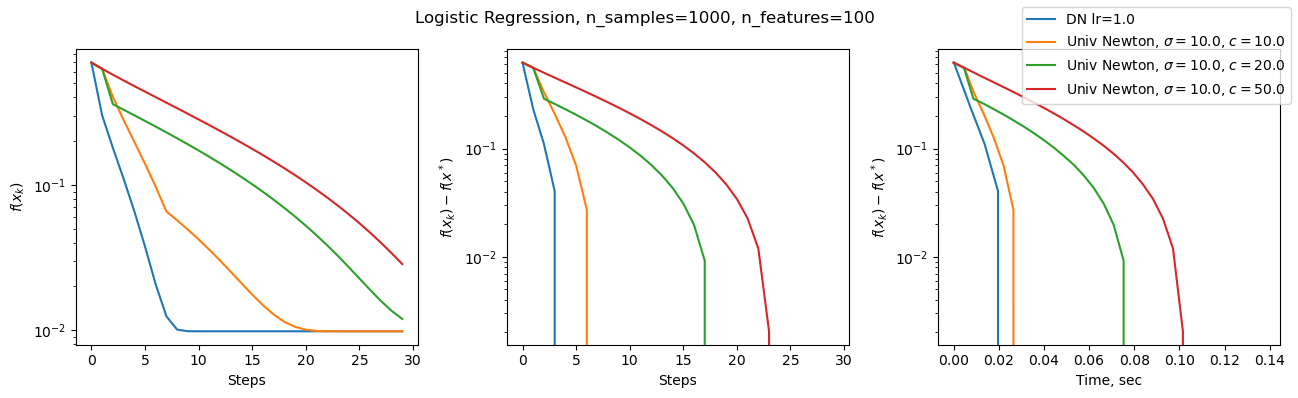

In [34]:
np.random.seed(0)

n_steps = 30
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# Damped Newton
lr = 1.0
hist = train_loop(method="damped_newton", lr=lr, n_steps=n_steps)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=f"DN lr={lr}")


# Universal Newton
for c, sigma, ls in zip([10.0, 20.0, 50.0], [10.0, 10.0, 10.0], [":", "-.", "--"]):
    hist = universal_newton(n_steps=n_steps, beta=2/3, sigma=sigma, c=c)
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(residual_loss, linestyle=ls)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, label=r"Univ Newton, $\sigma={0}$, $c={1}$".format(sigma, c))


        
plt.suptitle(f"Logistic Regression, n_samples={n_samples}, n_features={n_features}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[1].set_xlabel("Steps")
ax[2].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[2].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   

Step: [0/20]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/20]
Loss: 0.3010301891967697 | GradNorm^2: 0.016258805077985647 | Acc: 0.963
Step: [2/20]
Loss: 0.18010165773954223 | GradNorm^2: 0.002872649172793291 | Acc: 0.984
Step: [3/20]
Loss: 0.11037510646599923 | GradNorm^2: 0.0005563464540894169 | Acc: 0.994
Step: [4/20]
Loss: 0.06597670514185094 | GradNorm^2: 0.0001159745097888006 | Acc: 0.994
Step: [5/20]
Loss: 0.03768546542445122 | GradNorm^2: 2.5117370791464342e-05 | Acc: 0.996
Step: [6/20]
Loss: 0.02065183535437348 | GradNorm^2: 4.7001518204736986e-06 | Acc: 1.0
Step: [7/20]
Loss: 0.01246203616528906 | GradNorm^2: 7.349271996998146e-07 | Acc: 1.0
Step: [8/20]
Loss: 0.01009909464971969 | GradNorm^2: 7.394443891544976e-08 | Acc: 1.0
Step: [9/20]
Loss: 0.009841496241510615 | GradNorm^2: 2.642056477389925e-09 | Acc: 1.0
Step: [10/20]
Loss: 0.00983681549503959 | GradNorm^2: 4.993433593534988e-12 | Acc: 1.0
Step: [11/20]
Loss: 0.009836812129196053 | Gra

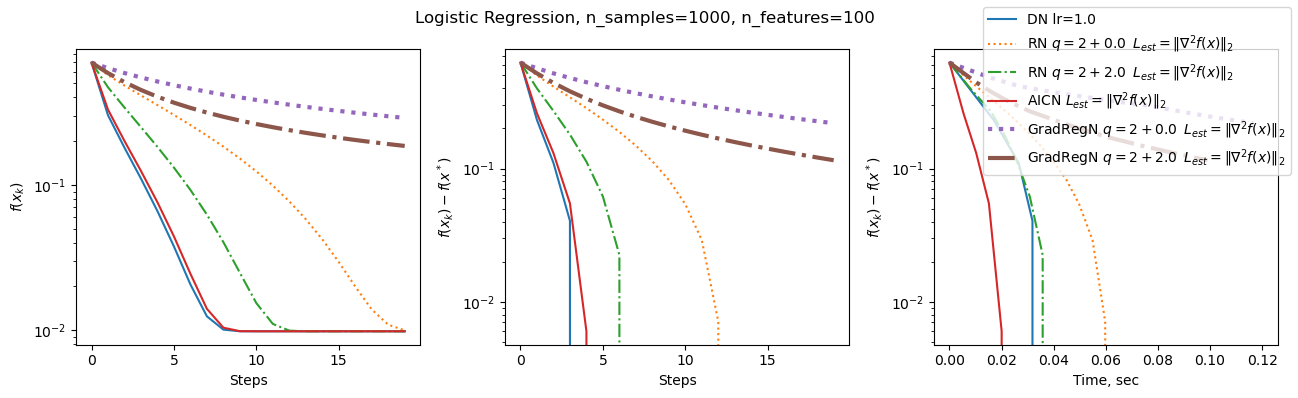

In [17]:
np.random.seed(0)

n_steps = 20
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# Damped Newton
lr = 1.0
hist = train_loop(method="damped_newton", lr=lr, n_steps=n_steps)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=f"DN lr={lr}")

# Root Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(method="root_newton", n_steps=n_steps, q=2+nu, L_est=None)
    
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(residual_loss, linestyle=ls)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, label=r"RN $q = 2 + {0} \;\; L_{{est}}=\| \nabla^2 f(x) \|_2$".format(nu))
    
        
# AICN
hist = train_loop(method="aic_newton", n_steps=n_steps, L_est=None)
residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(residual_loss)
ax[2].semilogy(hist["time"], residual_loss, label=r"AICN $L_{est}=\| \nabla^2 f(x) \|_2$")

# Gradient Regularization of Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(method="gradreg_newton", n_steps=n_steps, q=2+nu, L_est=None)
    
    residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
    ax[0].semilogy(hist["loss"], linestyle=ls, linewidth=3.0)
    ax[1].semilogy(residual_loss, linestyle=ls, linewidth=3.0)
    ax[2].semilogy(hist["time"], residual_loss, linestyle=ls, linewidth=3.0, label=r"GradRegN $q = 2 + {0} \;\; L_{{est}}=\| \nabla^2 f(x) \|_2$".format(nu))
    

# Super Newton
# hist = super_newton(n_steps=n_steps)
# residual_loss = hist["loss"] - loss_function(w_star, train_data, train_target)
# ax[0].semilogy(hist["loss"])
# ax[1].semilogy(residual_loss)
# ax[2].semilogy(hist["time"], residual_loss, label="Super-Univ")


        
plt.suptitle(f"Logistic Regression, n_samples={n_samples}, n_features={n_features}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[1].set_xlabel("Steps")
ax[2].set_ylabel(r"$f(x_k) - f(x^*)$")
ax[2].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   

In [102]:
from datetime import datetime

start_timestamp = datetime.now()
sorted(np.random.randn(1000000))
(datetime.now() - start_timestamp).total_seconds()

0.633528

In [103]:
from collections import defaultdict

defaultdict(list)

defaultdict(list, {})

Epoch: [0/20]
Loss: 0.6931471805599453 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Batch: [0/1]
Loss: 0.6931471805599453 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Epoch: [1/20]
Loss: 0.31860060713655214 | GradNorm^2: 0.01957354684293131 | Acc: 0.963
Batch: [0/1]
Loss: 0.31860060713655214 | GradNorm^2: 0.01957354684293131 | Acc: 0.963
Epoch: [2/20]
Loss: 0.196346771055311 | GradNorm^2: 0.003864932196749175 | Acc: 0.982
Batch: [0/1]
Loss: 0.196346771055311 | GradNorm^2: 0.003864932196749175 | Acc: 0.982
Epoch: [3/20]
Loss: 0.12458279627322999 | GradNorm^2: 0.0008265141544640061 | Acc: 0.993
Batch: [0/1]
Loss: 0.12458279627322999 | GradNorm^2: 0.0008265141544640061 | Acc: 0.993
Epoch: [4/20]
Loss: 0.07784749764222479 | GradNorm^2: 0.00018656954912131326 | Acc: 0.994
Batch: [0/1]
Loss: 0.07784749764222479 | GradNorm^2: 0.00018656954912131326 | Acc: 0.994
Epoch: [5/20]
Loss: 0.046935986641030665 | GradNorm^2: 4.439354616476388e-05 | Acc: 0.996
Batch: [0/1]
Loss: 0.046935986641030665 | G

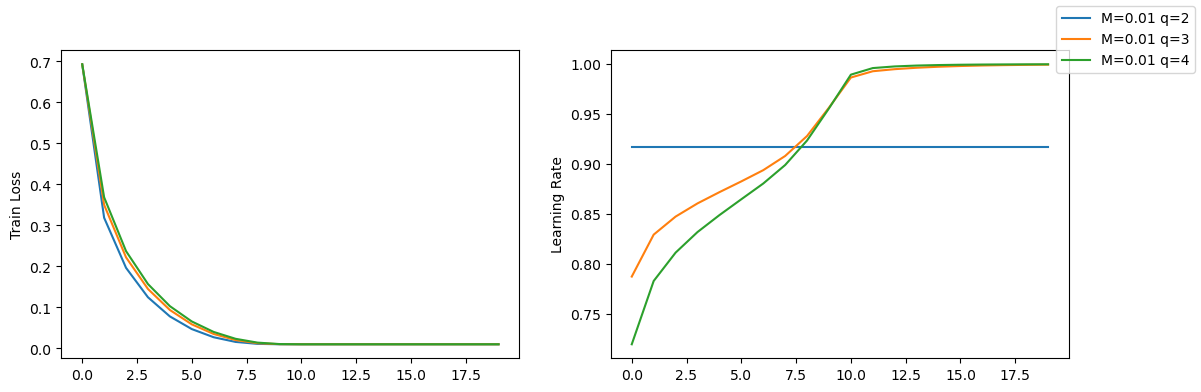

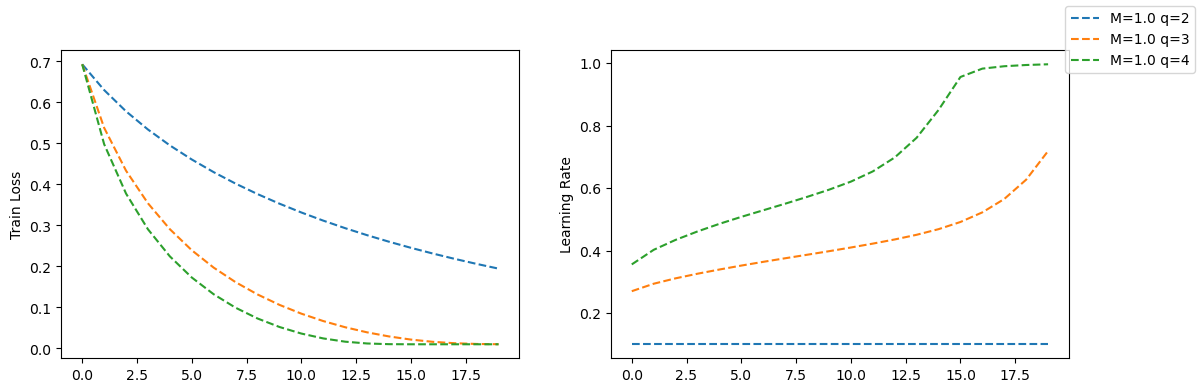

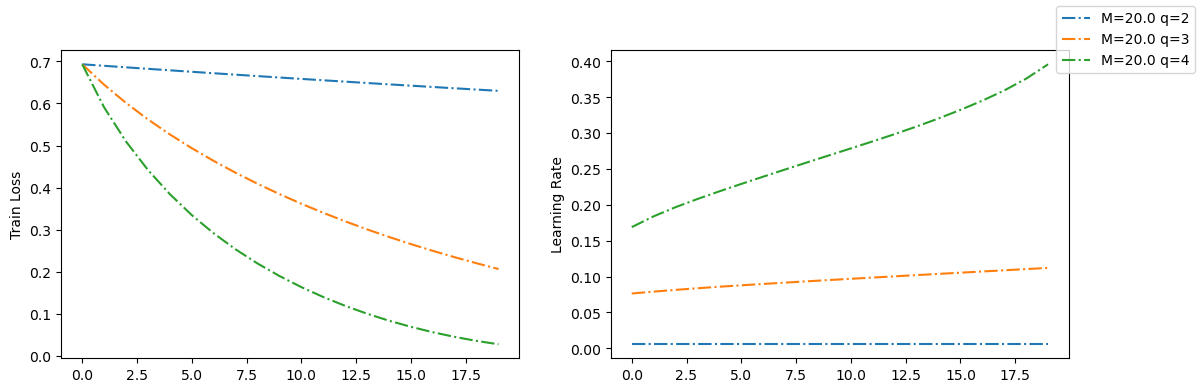

In [23]:
torch.manual_seed(0)

for M, ls in zip((0.01, 1.0, 20.0), ("-", "--", "-.")):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))
    
    for q in (2, 3, 4):

        epochs = 100
        data, target, dataloader = train

        # parameters
        w = torch.zeros(data.shape[1], device=device)

        # logging 
        hist = []
        hist_batch = []
        hist_lr = []
        total_n_batches = np.ceil(train_data.shape[0]/batch_size) * epochs
        # lr = 0.1
        # M = 0.1
        # q = 3

        for epoch in range(epochs):

            print(f"Epoch: [{epoch}/{epochs}]")
            loss = loss_function(w, data.to(device), target.to(device))
            grad = loss_grad(w, data.to(device), target.to(device))
            hess = loss_hessian(w, data.to(device), target.to(device))
            
            acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]
            print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(grad) ** 2 ).item()} | Acc: {acc}")
            hist.append([loss.item(), (torch.linalg.norm(grad) ** 2).item(), acc])

            for i, (batch_data, batch_target) in enumerate(dataloader):
                print(f"Batch: [{i}/{int(np.ceil(train_data.shape[0]/batch_size))}]")

                batch_data = batch_data.to(device)
                batch_target = batch_target.to(device)
                
                loss = loss_function(w, batch_data.to(device), batch_target.to(device))
                grad = loss_grad(w, batch_data.to(device), batch_target.to(device))
                hess = loss_hessian(w, batch_data.to(device), batch_target.to(device))
                hess_inv = torch.inverse(hess)
                
                n = hess_inv @ grad
                g_sq = grad.dot(n)
                g = torch.sqrt(g_sq)
                
                theta = (9 * M)**(1 / (q - 1)) * g**((q - 2) / (q - 1))
                lr = 1 / (1 + theta)
                hist_lr.append(lr)
                
                acc = (np.sign(data @ w.detach().numpy()) == target).sum() / target.shape[0]
                print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(grad) ** 2 ).item()} | Acc: {acc}")
                hist_batch.append([loss.item(), (torch.linalg.norm(grad) ** 2).item(), acc])


                w.sub_(n, alpha=lr)
                
        ax[0].plot([x[0] for x in hist_batch], linestyle=ls)
        ax[1].plot([x for x in hist_lr], linestyle=ls, label=f"M={M} q={q}")
            
    ax[0].set_ylabel("Train Loss")
    ax[1].set_ylabel("Learning Rate")
    fig.legend()
    fig.show()
    



In [119]:
torch.norm(w - w_star)

tensor(nan)